In this notebook, we'll filter the samples of the SwissProt dataset to only include those that have annotations that were experimentally verified or inferred by a human curator. We'll also remove any duplicate GO terms that may be assigned to the same sample.

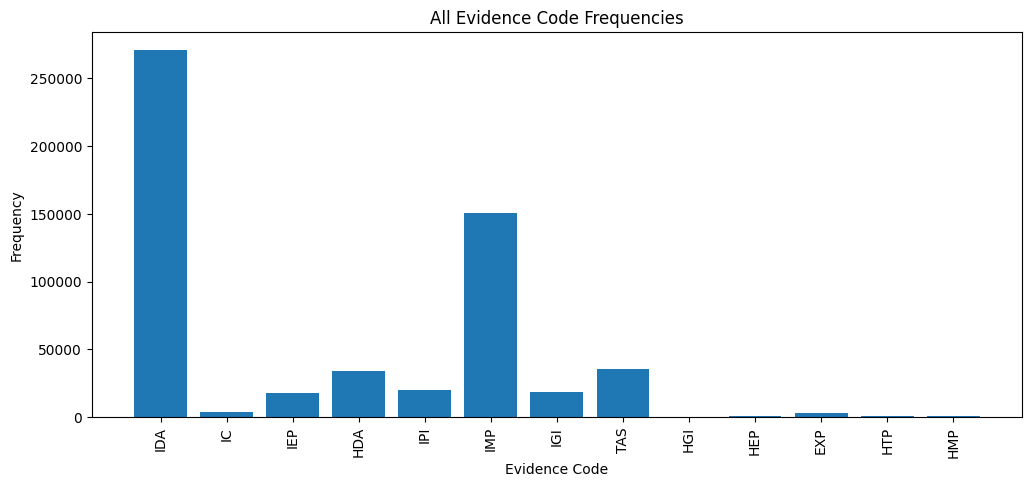

Dataset saved to ./dataset/all-filtered.jsonl
Filtered proportion: 84.94%


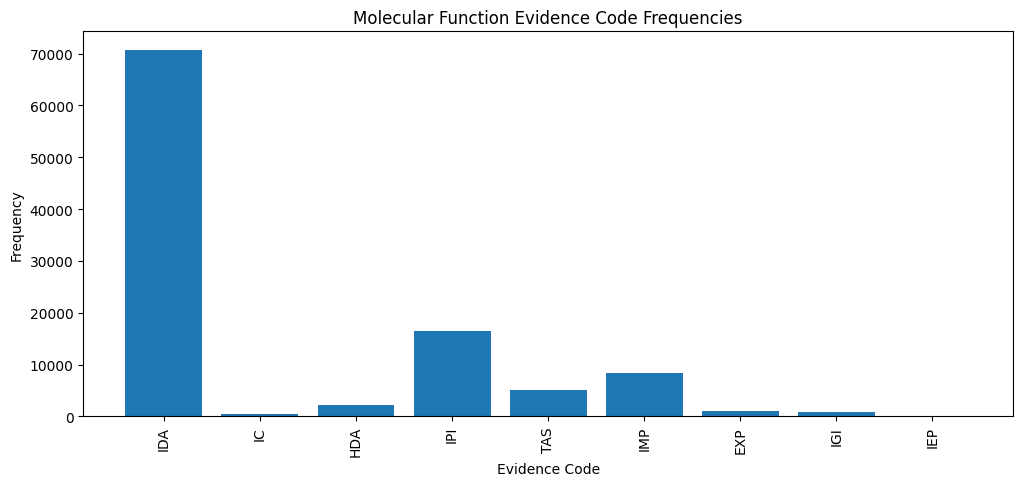

Dataset saved to ./dataset/mf-filtered.jsonl
Filtered proportion: 90.46%


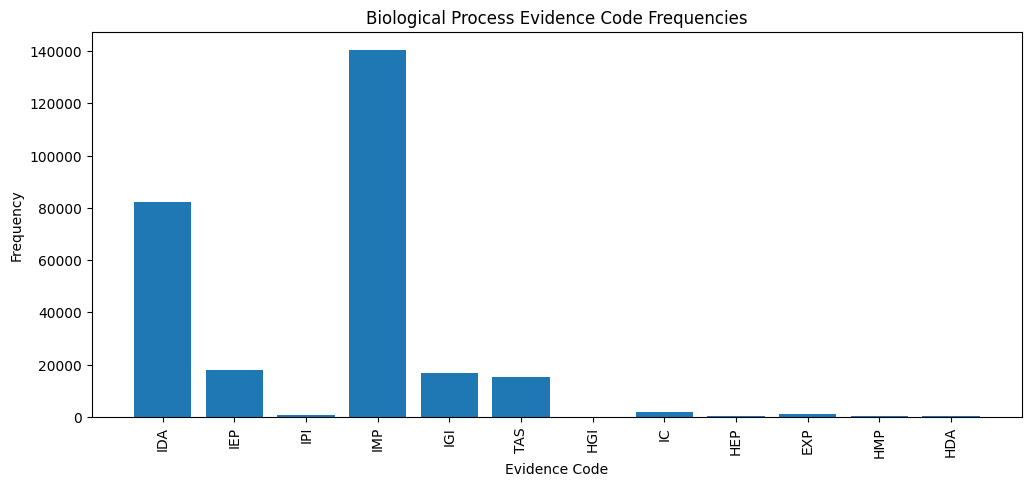

Dataset saved to ./dataset/bp-filtered.jsonl
Filtered proportion: 86.46%


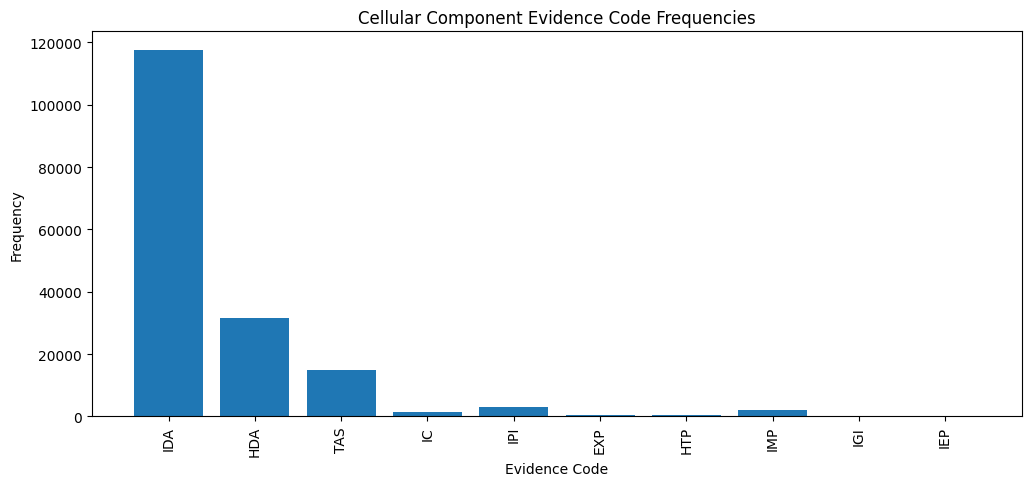

Dataset saved to ./dataset/cc-filtered.jsonl
Filtered proportion: 87.01%


In [3]:
from datasets import load_dataset

from collections import Counter

import matplotlib.pyplot as plt

import json

hf_dataset_name = "andrewdalpino/SwissProt-Gene-Ontology"

all_filtered_path = "./dataset/all-filtered.jsonl"
mf_filtered_path = "./dataset/mf-filtered.jsonl"
bp_filtered_path = "./dataset/bp-filtered.jsonl"
cc_filtered_path = "./dataset/cc-filtered.jsonl"

# Refer to https://geneontology.org/docs/guide-go-evidence-codes/.
EXPERIMENTAL_CODES = {"EXP", "IDA", "IPI", "IMP", "IGI", "IEP"}

HIGH_THROUGHPUT_CODES = {"HTP", "HDA", "HMP", "HGI", "HEP"}

PHYLOGENETICALLY_INFERRED_CODES = {"IBA", "IBD", "IKR", "IRD"}

COMPUTATIONAL_ANALYSIS_CODES = {"ISS", "ISO", "ISA", "ISM", "IGC", "RCA"}

OTHER_HUMAN_CURATED_CODES = {"TAS", "IC"}

admissible_evidence_codes = EXPERIMENTAL_CODES | HIGH_THROUGHPUT_CODES | OTHER_HUMAN_CURATED_CODES

for name, subset, filtered_path in [
    ("All", "all", all_filtered_path),
    ("Molecular Function", "mf", mf_filtered_path),
    ("Biological Process", "bp", bp_filtered_path),
    ("Cellular Component", "cc", cc_filtered_path),
]:
    dataset = load_dataset(hf_dataset_name, subset, split="train")

    counter = Counter()

    total_samples, num_filtered = 0, 0

    with open(filtered_path, "w") as file:
        for record in dataset:
            filtered_terms = set()

            total_samples += 1

            for go_term in record["terms"]:
                evidence_code = go_term["evidence_code"]

                if evidence_code in admissible_evidence_codes:
                    filtered_terms.add(go_term["id"])

                    counter[evidence_code] += 1

            if len(filtered_terms) == 0:
                num_filtered += 1

                continue

            record["go_terms"] = list(filtered_terms)

            del(record["terms"])

            file.write(json.dumps(record) + "\n")

    plt.figure(figsize=(12, 5)) 

    plt.bar(counter.keys(), counter.values())

    plt.title(f"{name} Evidence Code Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("Evidence Code")
    plt.ylabel("Frequency")

    plt.show()

    print(f"Dataset saved to {filtered_path}")

    print(f"Filtered proportion: {num_filtered / total_samples:.2%}")
